参考: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

このチュートリアルでは、1000クラスのImageNetのデータセットについて学習させたtorchvisionのモデルについて、finetuningと特徴量抽出の方法を学びます。  
これを通じて、最近のCNNの構造を見て、finetuningの方法も身に付けることができるでしょう。  
一口にモデルと言っても様々な構造があるので、全てのモデルについて働くfinetuningのコードはありません。  
各モデルについて最適なものを自分で実装するのが一般的です。  

ここでは2種類の転移学習を実装します。finetuningとfeature extractionです。  
finetuningでは、学習済みのモデルを用意し、その全てのパラメータを新しいタスクについて更新します。  
一方feature extractionでは、最後の層の重みのみを更新します。学習済みのCNNを特徴量抽出器とし、その部分はいじらずその後だけをいじっているのでfeature extractionと呼ばれています。

一般的には、どちらの場合も以下の手順で進めます。  
<ul>
    <li>学習済みのモデルを初期化します。</li>
    <li>最後の層の形を変えて、新たなタスクに沿うようにします。</li>
    <li>重みを更新する際の最適化関数を設定します。</li>
    <li>学習させます。</li>
</ul>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


# 入力

ここでは、これから更新するパラメータを示します。  
なおデータセットはhymenoptera_dataデータセットを使います。(https://download.pytorch.org/tutorial/hymenoptera_data.zip)  
このデータセットにはbeesとantsの2クラスがあり、ImageFolderデータセットを使えるようになっています。  

In [ ]:
# wgetでデータを取得し、unzipする
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P ./../data/
! unzip ./../data/hymenoptera_data.zip -d ./../data/

datadirには、ディレクトリの指定をきっちりしましょう。  
model_nameには使うモデルを下のリストから選択します。  
<ul>
    <li>resnet</li>
    <li>alexnet</li>
    <li>vgg</li>
    <li>squeezenet</li>
    <li>densenet</li>
    <li>inception</li>
</ul>

他の設定は下の通りです。  
<ul>
    <li>num_classes: データセットの中のクラスの数</li>
    <li>batch_size: バッチサイズ</li>
    <li>num_epochs: エポック数</li>
    <li>feature_extract: fintuningかfeature extractingをTrue or Falseで指定</li>
</ul>

In [2]:
data_dir="./../data/hymenoptera_data/" # データのディレクトリ 
model_name="squeezenet" # モデル
num_classes=2 # クラス数
batch_size=8 # バッチサイズ
num_epochs=15 # エポック数
feature_extract=True # [True,False]がそれぞれ[feature extraction,fine tuning]

# 関数の定義

モデルを実装する前に、関数を定義しておきましょう。

## モデルの学習・検証関数

モデルの学習・検証を行う関数をtrain_model()として実装します。  
入力として、PyTorchのモデル、データローダのdict、ロス関数、最適化関数、学習・検証のエポック数、Inceptionモデルかどうかのboolを受けます。  
is_inceptionはInception v3モデルを扱うものです。このモデルは通常の出力以外にも補助的なものも扱うため特別扱いされています。  
この関数では指定したエポック数学習させますが、各エポックで検証も行います。  
検証時のロスを見ながら、そのロスが最小のときのモデルを保ち、学習が終わったときには、それが最小のものを出力します。  
各エポックでは、学習と検証の精度を表示します。

In [3]:
def train_model(model,dataloaders,criterion,optimizer,num_epochs=25,is_inception=False):
    since=time.time() # 時間計測
    val_acc_history=[] # 検証精度のリスト
    best_model_wts=copy.deepcopy(model.state_dict()) # ベストの精度のときのモデルのパラメータ
    best_acc=0.0 # これまでの最高の精度
    
    for epoch in range(num_epochs): # 各エポックで
        print("Epoch {}/{}".format(epoch,num_epochs-1))
        print("-"*10)
        
        # 各エポックには学習・検証のフェーズがある
        for phase in ["train","val"]:
            if phase=="train": # 学習フェーズのとき
                model.train() # モデルを学習モードに
            else:
                model.eval() # モデルを検証モードに
                
            running_loss=0.0 # ロス
            running_corrects=0 # 正しく分類できた数
            
            # 各バッチについて
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device) # 入力
                labels=labels.to(device) # ラベル
                
                optimizer.zero_grad() # パラメータの勾配を初期化
                
                with torch.set_grad_enabled(phase=="train"): # 学習時のみ、ロスを見ながら行う
                    # モデルの出力を得て、ロスを計算する
                    # ただしInceptionのときは特別な操作をする、なぜなら出力の形式が違うから
                    # その場合、学習時には最終的な出力と補足的な出力を足し合わせるが、検証時には最終的な出力のみを見る
                    if is_inception and phase=="train": # Inceptionでかつ学習時に
                        # 参考: https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs,aux_outputs=model(inputs) # ネットワークの出力を取得
                        loss1=criterion(outputs,labels) # ロス1
                        loss2=criterion(aux_outputs,labels) # ロス2
                        loss=loss1+loss2 # ロス=ロス1+ロス2
                    else: # 検証時
                        outputs=model(inputs) # ネットワークの出力
                        loss=criterion(outputs,labels) # ロス
                        
                    _,preds=torch.max(outputs,1) # 予測クラスの用意
                    
                    ### 訓練時のみ逆伝搬を行う
                    if phase=="train":
                        loss.backward() # 逆伝搬
                        optimizer.step() # 最適化する
                        
                ### 精度算出
                running_loss+=loss.item()*inputs.size(0) # ロス
                running_corrects+=torch.sum(preds==labels.data) # 正しく分類できた数
                
            epoch_loss=running_loss/len(dataloaders[phase].dataset) # エポックでのロス
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset) # エポックでの精度
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase,epoch_loss,epoch_acc))
            
            ### モデルをコピー
            if phase=="val" and epoch_acc>best_acc: # もし精度が過去最高なら
                best_acc=epoch_acc # ベストを更新
                best_model_wts=copy.deepcopy(model.state_dict()) # ベスト時のパラメータ
            if phase=="val":
                val_acc_history.append(epoch_acc)
                
        print()
        
    ### ここまでで学習・検証が済み
    time_elapsed=time.time()-since # 実行時間の算出
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed//60,time_elapsed%60))
    print("Best val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts) # ベストのモデルの重みをロードする
    
    return model,val_acc_history

## モデルのパラメータのrequires_grad()を設定する関数

この関数では、feature extractingしているときはrequires_grad()をfalseに設定します。  
デフォルトでは、学習済みモデルをロードした時には全てのパラメータはrequires_grad=Trueとなっています。これはfine tuningのときには問題ないのですが、feature extractingをしていて、新しく初期化したレイヤについて勾配を計算したいだけの場合は、いらない部分についてはfalseとします。  

In [4]:
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting: # feature extractingの場合
        for param in model.parameters():
            param.requires_grad=False

# ネットワークの初期化とreshape

ここではネットワークのreshapeをします。一般的に、CNNの最終層では出力クラスと同じサイズのノードがあります。  
Imagenetのものの場合、サイズは1000です。  
ここでは、今回のタスクのために入力と出力のサイズを変更します。  
後の節では、どのようにモデルの構造を変更するかを見ます。  
まずは、finetuningとfeature extractionの違いを確認しましょう。

feature extractingでは、最後の層の重みだけを更新したいです。なので、それ以外の層の重みのrequires_gradはfalseとします。  
これで効率化できます。  
一方finetuningする場合は全てをtrueとします。  
ちなみに、Inception v3の入力のサイズは(299,299)で、他のものは(224,224)です。

## Resnet

Resnetは[この論文](https://arxiv.org/abs/1512.03385)で提案されたものです。  
サイズによってResnet18,Resnet34,Resnet50,Resnet101,Resnet152といったバリエーションがあります。これらはtorchvisionで利用できます。  
ここでは、データセットが小さいのと2クラスしかないのでResnet18を使います。  
モデルをprintすると、最後の層が全結合層であることを確認できます。

In [7]:
torchvision.models.resnet18() # resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

なので、model.fcを下のように変更します。

In [ ]:
# ここでは実際には変更しない、考え方を示しているだけ
model.fc=nn.Linear(512,num_classes)

## Alexnet

Alexnetは[この論文](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)で提案されたものです。  
ImageNetのデータセットにおける、CNNの成功例として知られています。  
モデルをprintすると、最後の層の形を確認できます。

In [8]:
torchvision.models.alexnet() # Alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

ここでは下のように変更します。

In [ ]:
model.classifier[6]=nn.Linear(4096,num_classes)

## VGG

VGGは[この論文](https://arxiv.org/pdf/1409.1556.pdf)で提案されました。  
torchvisionには8種類のバリエーションがあります。batch normalizationの層を持つものもあります。  
ここではbatch normalizationのあるVGG-11を使います。

In [9]:
torchvision.models.vgg11_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

下のように変更します。

In [ ]:
model.classifier[6]=nn.Linear(4096,num_classes)

## Squeezenet

Squeezenetは[この論文](https://arxiv.org/abs/1602.07360)で説明されています。  
これまでに見てきた他のモデルとは違う出力の方法を取っています。  
torchvisionには2種類のバリエーションがあります。ここではversion 1.0を使います。  
出力は分類器の最初の層の1x1のconvolution層から得られます。

In [10]:
torchvision.models.squeezenet1_0()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

ネットワークを変更するにはしたのようにします。

In [ ]:
model.classifier[1]=nn.Conv2d(512,num_classes,kernel_size=(1,1),stride=(1,1))

## Densenet

Densenetは[この論文](https://arxiv.org/abs/1608.06993)で提案されました。  
torchvisionには4種類ありますが、ここではDensenet-121を使います。  
出力層は1024の入力です。

In [11]:
torchvision.models.densenet121()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

下のようにします。

In [ ]:
model.classifier=nn.Linear(1024,num_classes)

## Inception v3

Inception v3は[この論文](https://arxiv.org/pdf/1512.00567v1.pdf)で説明されています。  
このネットワークは学習時に2つの出力層がある点でユニークです。  
2つ目の出力はauxiliary outputと呼ばれ、ネットワークのAuxLogitsの部分に含まれています。  
primary outputはネットワークの最後の線形の層です。  
テスト時にはこのprimary outputだけ見ます。  
primary outputとauxiliary outputは下のように確認できます。

In [16]:
torchvision.models.inception_v3()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

finetuningするためには、2つの層を変更する必要があります。

In [ ]:
model.AuxLogits.fc=nn.Linear(768,num_classes)
model.fc=nn.Linear(2048,num_classes)

## まとめ

各モデルは似たような形をしていますが、それぞれに対応したように書く必要があります。  
出力のサイズが望んだ通りになっているかを確認しておきましょう。

In [17]:
def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    """
    feature_extract: feature_extractかfinetuningか
    """
    model_ft=None
    input_size=0
    
    if model_name=="resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)  # resnetを使う
        set_parameter_requires_grad(model_ft, feature_extract) #  requires_grad()の設定
        num_ftrs = model_ft.fc.in_features # 特徴量のサイズ
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # 最後の層
        input_size = 224
    elif model_name=="alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained) # alexnetを使う
        set_parameter_requires_grad(model_ft, feature_extract) # requires_grad()の設定
        num_ftrs = model_ft.classifier[6].in_features # 特徴量のサイズ
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes) # 最後の層
        input_size = 224
    elif model_name=="vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained) # vgg11(batch normalizationあり)を使う
        set_parameter_requires_grad(model_ft, feature_extract) # requires_grad()の設定
        num_ftrs = model_ft.classifier[6].in_features # 特徴量のサイズ
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes) # 最後の層
        input_size = 224
    elif model_name=="squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained) # squeezenetを使う
        set_parameter_requires_grad(model_ft, feature_extract) # requires_grad()の設定
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1)) # 最後の層
        model_ft.num_classes = num_classes
        input_size = 224
    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained) # densenetを使う
        set_parameter_requires_grad(model_ft, feature_extract) # requires_grad()の設定
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) # 最後の層
        input_size = 224
    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained) # Inception v3を使う
        set_parameter_requires_grad(model_ft, feature_extract) # requires_grad()の設定
        
        # auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features # 特徴量のサイズ
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes) # 最後の層
        
        # primary net
        num_ftrs = model_ft.fc.in_features # 特徴量のサイズ
        model_ft.fc = nn.Linear(num_ftrs,num_classes) # 最後の層
        input_size = 299
    else: # モデルの名前が不適切の場合
        print("モデルの名前を確認してください。")
        exit()
        
    return model_ft,input_size

それでは実行してみます。今回はsqueezenetです。

In [18]:
model_ft,input_size=initialize_model(model_name=model_name,
                                     num_classes=num_classes,
                                     feature_extract=feature_extract,
                                     use_pretrained=True
                                    )

print(model_ft)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/ubuntu/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth
100.0%


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

# データのロード

## データローダの設定

入力のサイズが分かるので、データのtransforms, datasets, dataloaderを設定できます。  
モデルは[ここ](https://pytorch.org/docs/master/torchvision/models.html)で示されるように、hard-codedなnormalizationの値で学習済みです。

In [19]:
# 学習時にはdata augmentationとnormalization
# 検証時にはnormalizationのみ
data_transforms={
    "train":transforms.Compose(
        [
            transforms.RandomResizedCrop(input_size), # 一部を切り取る
            transforms.RandomHorizontalFlip(), # 水平方向に回転
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 正規化
        ]
    ),
    "val":transforms.Compose(
        [
            transforms.Resize(input_size), # サイズを合わせる
            transforms.CenterCrop(input_size), # 中心に揃える
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 正規化
        ]
    )
}

print("DatasetsとDataloadersを設定中...")

DatasetsとDataloadersを設定中...


## データセットの作成

In [20]:
### dataset
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ["train","val"]} # 画像のデータセット

### dataloader
dataloaders_dict={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True,num_workers=4) for x in {"train","val"}}

### デバイスの設定
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 最適化関数の設定

ここまででモデルの構築ができました。  
最後に最適化を設定します。  
ここで再確認します。学習済みのモデルをロードしたとき、reshapeの前では、feature_extract=Trueのときは全てのパラメータについて、requires_grad=Falseです。  
そして新たに作った層では、デフォルトでrequires_grad=Trueとなっています。  
全てのrequires_grad=Trueの部分で学習することになります。  
そこで、これら学習したいパラメータのリストを作り、それをSGDのアルゴリズムに入れます。  

まず学習したいパラメータを表示してみましょう。  
finetuningの際には、全てのパラメータが入ります。  
feature extractingの場合には、新しい層の重みとバイアスのみが入ります。

In [22]:
model_ft=model_ft.to(device) # モデルをデバイスに送る

# 最適化したいパラメータを集める
# finetuningの場合は、全てのパラメータを更新する
# feature extractの場合は、新たな層のパラメータのみ更新する

params_to_update=model_ft.parameters() # 最適化したいパラメータ
print("最適化したいパラメータ:")

if feature_extract: # feature extractionの場合
    params_to_update=[] # 更新したいパラメータ
    
    for name,param in model_ft.named_parameters(): # 各パラメータについて
        if param.requires_grad==True: # もしそのパラメータが、更新したいものならば
            params_to_update.append(param)
            print("\t",name)
else: # finetuningの場合
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:
            print("\t",name)
            
optimizer_ft=optim.SGD(params_to_update,lr=0.001,momentum=0.9) # 最適化関数

最適化したいパラメータ:
	 classifier.1.weight
	 classifier.1.bias


# 学習・検証

最後に、モデルのロスを定義します。  
そして指定したエポックの数だけ学習をします。  
ここでは学習率は適当（口語）に定めますが、精度を上げたい場合はこの設定も試行錯誤してください。

In [23]:
criterion=nn.CrossEntropyLoss() # クロスエントロピー誤差

model_ft,hist=train_model(
    model=model_ft, # モデル
    dataloaders=dataloaders_dict, # dataloader
    criterion=criterion, # ロス関数
    optimizer=optimizer_ft, # 最適化関数
    num_epochs=num_epochs, # エポック数
    is_inception=(model_name=="inception") # Inception v3かどうか
)

Epoch 0/14
----------
train Loss: 0.4688 Acc: 0.7541
val Loss: 0.3337 Acc: 0.8889

Epoch 1/14
----------
train Loss: 0.3114 Acc: 0.8607
val Loss: 0.3095 Acc: 0.9020

Epoch 2/14
----------
train Loss: 0.2615 Acc: 0.8852
val Loss: 0.3467 Acc: 0.8954

Epoch 3/14
----------
train Loss: 0.1998 Acc: 0.9385
val Loss: 0.2808 Acc: 0.9346

Epoch 4/14
----------
train Loss: 0.1881 Acc: 0.9303
val Loss: 0.3086 Acc: 0.9281

Epoch 5/14
----------
train Loss: 0.1829 Acc: 0.9426
val Loss: 0.3076 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.1866 Acc: 0.9385
val Loss: 0.2861 Acc: 0.9281

Epoch 7/14
----------
train Loss: 0.1271 Acc: 0.9508
val Loss: 0.2975 Acc: 0.9281

Epoch 8/14
----------
train Loss: 0.1398 Acc: 0.9508
val Loss: 0.3209 Acc: 0.9346

Epoch 9/14
----------
train Loss: 0.1663 Acc: 0.9221
val Loss: 0.3172 Acc: 0.9346

Epoch 10/14
----------
train Loss: 0.1302 Acc: 0.9467
val Loss: 0.3691 Acc: 0.9020

Epoch 11/14
----------
train Loss: 0.1604 Acc: 0.9262
val Loss: 0.3220 Acc: 0.9216

Ep

ロス、精度を表示できました。  
エポックを経るごとに良くなってゆくことが確認できました。

# スクラッチモデルと比較

## スクラッチの学習

それでは転移学習をしないものとパフォーマンスの比較をしてみましょう。  
スクラッチのものと比べるとデータセットの差でスクラッチに有利な部分はありますが、実行時間で見れば転移学習ありの方が早いでしょう。

In [30]:
### スクラッチのモデルを用意

scratch_model,_=initialize_model(
    model_name=model_name, # モデル名
    num_classes=num_classes, # クラス数
    feature_extract=False, # finetuning
    use_pretrained=False # 学習済みのものを使わない
)

scratch_model=scratch_model.to(device) # モデルをデバイスに送る
scratch_optimizer=optim.SGD(scratch_model.parameters(),lr=0.001,momentum=0.9) # 最適化関数
scratch_criterion=nn.CrossEntropyLoss() # ロス関数

_,scratch_hist=train_model(
    model=scratch_model,
    dataloaders=dataloaders_dict,
    criterion=scratch_criterion,
    optimizer=scratch_optimizer,
    num_epochs=num_epochs,
    is_inception=(model_name=="inception")
)

Epoch 0/14
----------
train Loss: 0.7364 Acc: 0.4631
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6931 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6930 Acc: 0.5410
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6931 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6929 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6929 Acc: 0.5000
val Loss: 0.6931 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6926 Acc: 0.4959
val Loss: 0.6931 Acc: 0.5163

Epoch 7/14
----------
train Loss: 0.6919 Acc: 0.4959
val Loss: 0.6898 Acc: 0.5752

Epoch 8/14
----------
train Loss: 0.6934 Acc: 0.4959
val Loss: 0.6932 Acc: 0.4706

Epoch 9/14
----------
train Loss: 0.6907 Acc: 0.4918
val Loss: 0.6927 Acc: 0.5621

Epoch 10/14
----------
train Loss: 0.6937 Acc: 0.5287
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6931 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Ep

## 結果の表示

結果を表示します。

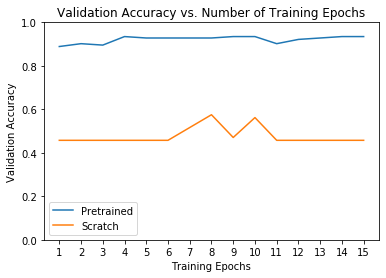

In [31]:
### 検証精度とエポック数の表示
ohist=[]
shist=[]

ohist=[h.cpu().numpy() for h in hist] # 転移学習
shist=[h.cpu().numpy() for h in scratch_hist] # スクラッチ

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1,num_epochs+1,1.0))
plt.legend()
plt.show()